# Code for multi-modal retrieval:
- creating (poster image + short text desc) documents
- fusing text and image embeddings and indexing with CLIP
- testing:
    -  searches with queries over all docs

In [1]:
import pandas as pd
import time as tm
import numpy as np
from path import Path

from src.data.document_creators import create_poster_docs
from src.data.chunk import chunk
from src.retrievers.visual_retriever import VisualRetriever
import random
import PIL

In [2]:
# Load data
print("\n1. Loading movie poster data...")
path = Path('/Users/saghar/Desktop/movie-rag/datasets/rotten-tomatoes-reviews/prep')
posters_df = pd.read_csv(path / 'movie_posters.csv')

# add a year column for date
posters_df['release_year'] = pd.to_datetime(posters_df['original_release_date']).dt.year
print(f"Loaded {len(posters_df)} posters")

# Create documents
print("\n2. Creating documents...")
movie_id_cols = ['rotten_tomatoes_link', 'movie_title', 'release_year']
obj_metadata_cols = ['rotten_tomatoes_link', 'movie_title', 'release_year', 'original_release_date', 'authors', 'actors', 'production_company', 'genres', 'imdb_rating', 'box_office', 'content_rating', 'runtime', 'tomatometer_rating', 'tomatometer_count', 'audience_rating', 'audience_count', 'tomatometer_top_critics_count', 'tomatometer_fresh_critics_count', 'tomatometer_rotten_critics_count']

visual_docs = create_poster_docs(posters_df, obj_metadata_cols)



1. Loading movie poster data...
Loaded 6431 posters

2. Creating documents...
Created 6079 poster docs.


In [3]:
sample_docs = random.sample(visual_docs, 1000)  # small number since model is local

In [4]:
# Set up retriever
visual_retriever = VisualRetriever(model_name="ViT-B/32", use_text_fusion=True, alpha=0.8)
visual_retriever.add_documents(sample_docs)

Loading CLIP model: ViT-B/32
✓ CLIP loaded on cpu
✓ VisualRetriever (text_fusion=True, method=weight_average)
  Alpha: 0.8 (image=0.8, text=0.2)
Encoding 1000 posters with CLIP...
Encoding 1000 text descriptions with CLIP...
✓ Fused embeddings using weight_average method (dim=512)
✓ Added 1000 posters to index


In [9]:
from IPython.display import display
from src.retrievers.base import CustomBaseRetriever

def run(all_docs: list[dict], retriever: CustomBaseRetriever, test_queries: list[str], save: bool = False, k: int = 3):
    """Test search results, time, and save and load functionality"""
    print("\n Testing searches...")

    times = []

    for query in test_queries:
        print(f"\n{'=' * 60}")
        print(f"Query: '{query}'")
        print('=' * 60)

        start = tm.time()
        results = retriever.search(query, k=k)
        time = tm.time() - start
        times.append(time)

        for i, (doc, score) in enumerate(results, 1):
            print(f"\nResult {i} (score={score:.4f}):")
            print(f"  Movie: {doc['metadata'].get('movie_title', 'Unknown')}")
            print(f"  Year: {doc['metadata'].get('release_year', 'N/A')}")
            print(f"  Poster text: {doc['text_content']}")
            print("  Poster image:")
            with PIL.Image.open(doc['poster_path']) as img:
                display(img)

        print("\n" + "=" * 60)
        print("SUMMARY")
        print("=" * 60)
        print(f"Average time: {np.mean(times) * 1000:.2f}ms")
        print(f"Total docs indexed: {len(all_docs)}")

    if save:
        # Save retriever
        print("\nSaving retriever...")
        retriever.save("models/visual_retriever")

        # Test loading
        print("\nTesting load...")
        new_retriever = FaissDenseRetriever()
        new_retriever.load("models/visual_retriever")

        results = new_retriever.search("dreams", k=1)
        print(f"✓ Loaded retriever works: {results[0][0]['metadata']['movie_title']}")

Test retrieval on some queries. They're a mix of text and poster queries. We expect it to perform better on poster queries since alpha is high.

In [7]:
test_queries = [
    "2010 action movie starring Tom Cruise",
    "Christopher Nolan sci-fi thriller from 2014",
    "Romantic comedy with Jennifer Lawrence and Bradley Cooper",
    "A dark, moody action poster with explosions",
    "Bright, colorful animated movie poster with animals",
    "Horror poster with red text and a haunted house",
    "Sci-fi movie from 2014 with a blue-toned poster and spaceships",
    "Romantic comedy starring Julia Roberts with a cheerful poster",
    "Action thriller with Tom Cruise and a poster showing a car chase"
]

running visual retriever


 Testing searches...

Query: '2010 action movie starring Tom Cruise'

Result 1 (score=0.6176):
  Movie: Epic Movie
  Year: 2007
  Poster text: Epic Movie. (2007). Action & Adventure, Comedy. directed by Aaron Seltzer. actors: Kal Penn,  Adam Campbell,  Jayma Mays,  Faune A. Chambers,  Crispin Glover.
  Poster image:


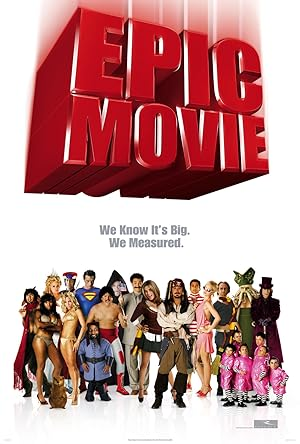


Result 2 (score=0.6202):
  Movie: Torque
  Year: 2004
  Poster text: Torque. (2004). Action & Adventure. directed by Joseph Kahn. actors: Martin Henderson,  Ice Cube,  Monet Mazur,  Matt Schulze,  Jay Hernandez.
  Poster image:


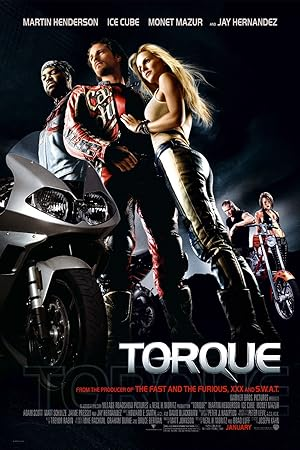


Result 3 (score=0.6211):
  Movie: Wedding Crashers
  Year: 2005
  Poster text: Wedding Crashers. (2005). Comedy, Romance. directed by David Dobkin. actors: Owen Wilson,  Vince Vaughn,  Rachel McAdams,  Christopher Walken,  Isla Fisher.
  Poster image:


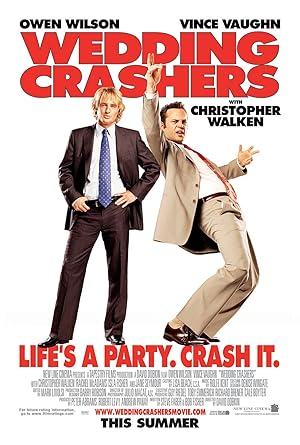


SUMMARY
Average time: 198.51ms
Total docs indexed: 1000

Query: 'Christopher Nolan sci-fi thriller from 2014'

Result 1 (score=0.6246):
  Movie: The International
  Year: 2009
  Poster text: The International. (2009). Drama, Mystery & Suspense. directed by Tom Tykwer. actors: Clive Owen,  Naomi Watts,  Armin Mueller-Stahl,  Ulrich Thomsen,  Brian F. O'Byrne.
  Poster image:


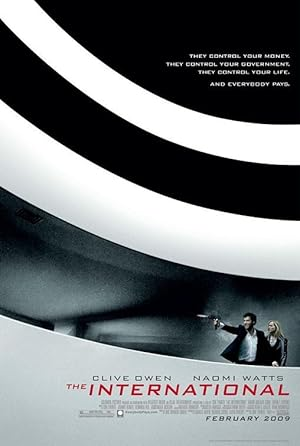


Result 2 (score=0.6442):
  Movie: The Rental
  Year: 2020
  Poster text: The Rental. (2020). Horror, Mystery & Suspense. directed by Dave Franco. actors: Dan Stevens,  Alison Brie,  Sheila Vand,  Toby Huss.
  Poster image:


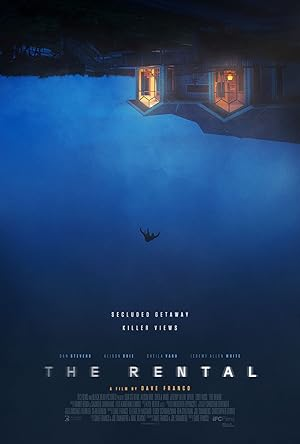


Result 3 (score=0.6497):
  Movie: Alone
  Year: 2020
  Poster text: Alone. (2020). Mystery & Suspense. directed by John Hyams. actors: Jules Willcox,  Marc Menchaca,  Anthony Heald.
  Poster image:


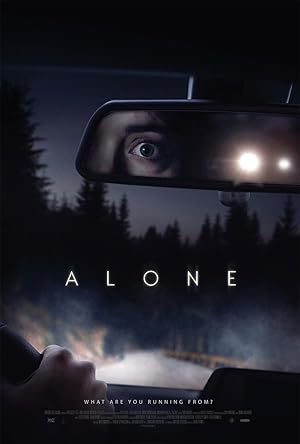


SUMMARY
Average time: 117.48ms
Total docs indexed: 1000

Query: 'Romantic comedy with Jennifer Lawrence and Bradley Cooper'

Result 1 (score=0.6380):
  Movie: Joy
  Year: 2015
  Poster text: Joy. (2015). Drama. directed by David O. Russell. actors: Jennifer Lawrence,  Robert De Niro,  Bradley Cooper,  Edgar Ramirez,  Diane Ladd.
  Poster image:


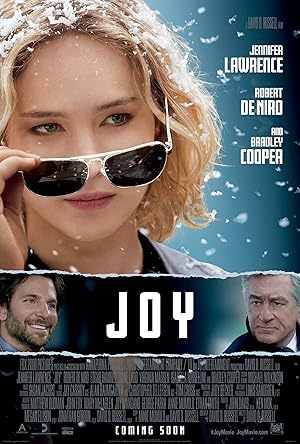


Result 2 (score=0.7234):
  Movie: Light of My life
  Year: 2019
  Poster text: Light of My life. (2019). Drama. directed by Casey Affleck. actors: Anna Pniowsky,  Casey Affleck,  Tom Bower,  Elisabeth Moss,  Timothy Webber.
  Poster image:


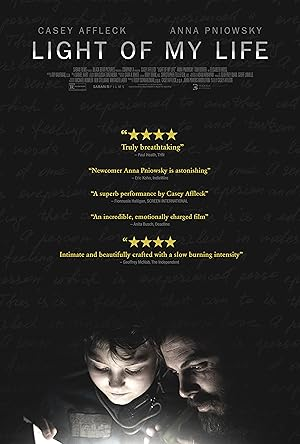


Result 3 (score=0.7250):
  Movie: The Other Woman
  Year: 2014
  Poster text: The Other Woman. (2014). Comedy. directed by Nick Cassavetes. actors: Cameron Diaz,  Leslie Mann,  Kate Upton,  Nikolaj Coster-Waldau,  Nicki Minaj.
  Poster image:


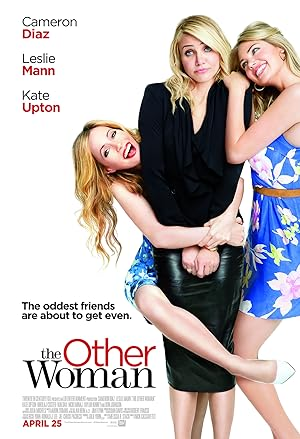


SUMMARY
Average time: 90.62ms
Total docs indexed: 1000

Query: 'A dark, moody action poster with explosions'

Result 1 (score=0.8028):
  Movie: Demon
  Year: 2016
  Poster text: Demon. (2016). Art House & International, Mystery & Suspense. directed by Marcin Wrona. actors: Itay Tiran,  Agnieszka Zulewska,  Andrzej Grabowski,  Tomasz Schuchardt,  Katarzyna Herman.
  Poster image:


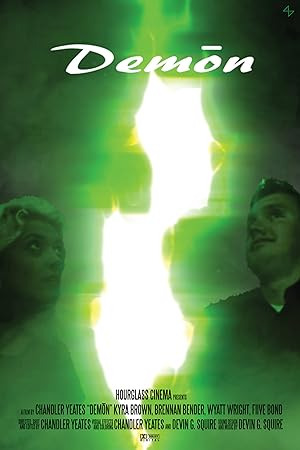


Result 2 (score=0.8103):
  Movie: Alone
  Year: 2020
  Poster text: Alone. (2020). Mystery & Suspense. directed by John Hyams. actors: Jules Willcox,  Marc Menchaca,  Anthony Heald.
  Poster image:


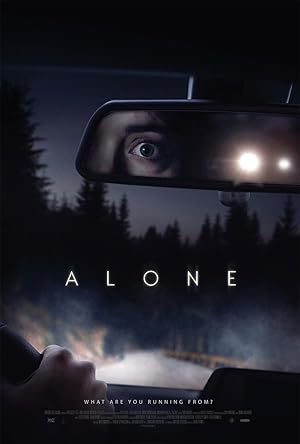


Result 3 (score=0.8274):
  Movie: The International
  Year: 2009
  Poster text: The International. (2009). Drama, Mystery & Suspense. directed by Tom Tykwer. actors: Clive Owen,  Naomi Watts,  Armin Mueller-Stahl,  Ulrich Thomsen,  Brian F. O'Byrne.
  Poster image:


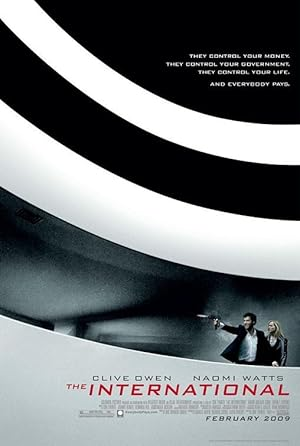


SUMMARY
Average time: 76.80ms
Total docs indexed: 1000

Query: 'Bright, colorful animated movie poster with animals'

Result 1 (score=0.7643):
  Movie: The Jungle Book 2
  Year: 2003
  Poster text: The Jungle Book 2. (2003). Animation, Kids & Family. directed by Steve Trenbirth. actors: John Goodman,  Haley Joel Osment,  Mae Whitman,  Jim Cummings,  Phil Collins.
  Poster image:


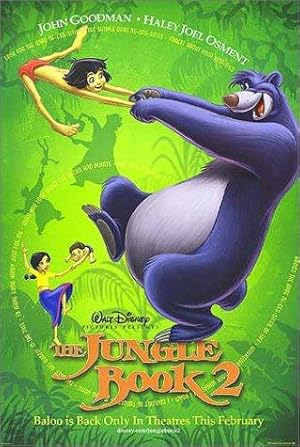


Result 2 (score=0.7818):
  Movie: Bull
  Year: 2020
  Poster text: Bull. (2020). Drama. directed by Annie Silverstein. actors: Rob Morgan,  Amber Havard,  Yolonda Ross,  Keeli Wheeler,  Keira Bennett.
  Poster image:


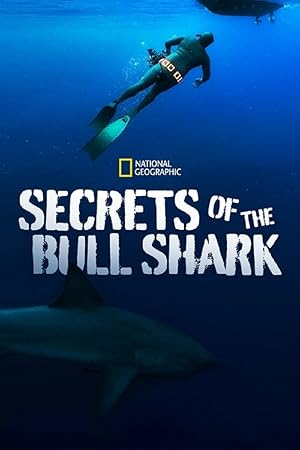


Result 3 (score=0.8081):
  Movie: The Rental
  Year: 2020
  Poster text: The Rental. (2020). Horror, Mystery & Suspense. directed by Dave Franco. actors: Dan Stevens,  Alison Brie,  Sheila Vand,  Toby Huss.
  Poster image:


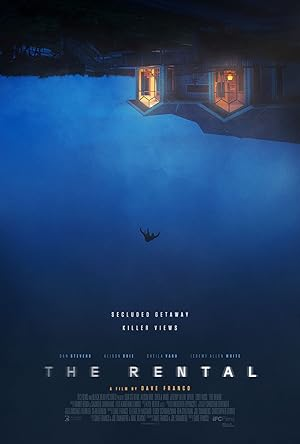


SUMMARY
Average time: 68.45ms
Total docs indexed: 1000

Query: 'Horror poster with red text and a haunted house'

Result 1 (score=0.7670):
  Movie: We Are Still Here
  Year: 2015
  Poster text: We Are Still Here. (2015). Horror. directed by Ted Geoghegan. actors: Barbara Crampton,  Andrew Sensenig,  Lisa Marie,  Larry Fessenden,  Monte Markham.
  Poster image:


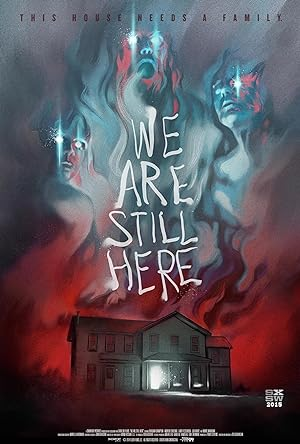


Result 2 (score=0.7765):
  Movie: The Rental
  Year: 2020
  Poster text: The Rental. (2020). Horror, Mystery & Suspense. directed by Dave Franco. actors: Dan Stevens,  Alison Brie,  Sheila Vand,  Toby Huss.
  Poster image:


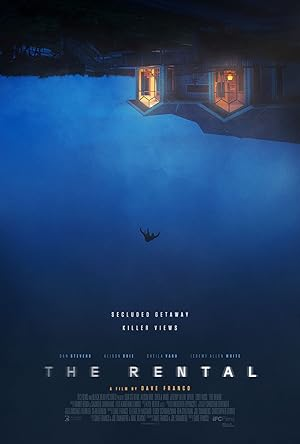


Result 3 (score=0.7870):
  Movie: UNDEAD
  Year: 2005
  Poster text: UNDEAD. (2005). Horror, Science Fiction & Fantasy. directed by Michael Spierig. actors: Felicity Mason,  Mungo McKay,  Rob Jenkins,  Lisa Cunningham,  Dirk Hunter.
  Poster image:


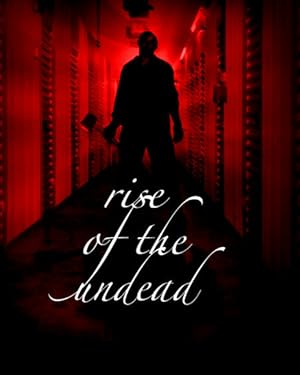


SUMMARY
Average time: 63.08ms
Total docs indexed: 1000

Query: 'Sci-fi movie from 2014 with a blue-toned poster and spaceships'

Result 1 (score=0.7388):
  Movie: Alone
  Year: 2020
  Poster text: Alone. (2020). Mystery & Suspense. directed by John Hyams. actors: Jules Willcox,  Marc Menchaca,  Anthony Heald.
  Poster image:


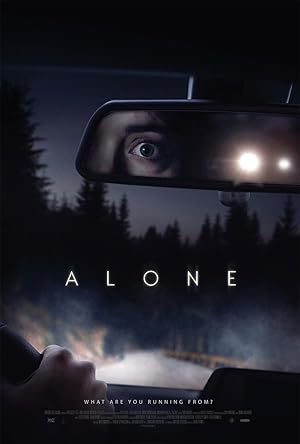


Result 2 (score=0.7523):
  Movie: The Rental
  Year: 2020
  Poster text: The Rental. (2020). Horror, Mystery & Suspense. directed by Dave Franco. actors: Dan Stevens,  Alison Brie,  Sheila Vand,  Toby Huss.
  Poster image:


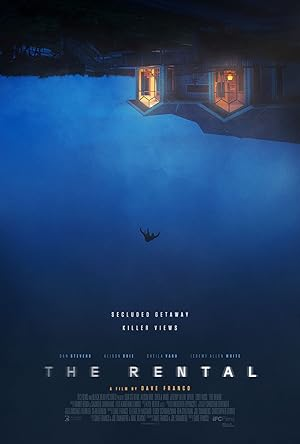


Result 3 (score=0.7552):
  Movie: Lost in Space
  Year: 1998
  Poster text: Lost in Space. (1998). Action & Adventure, Science Fiction & Fantasy. directed by Stephen Hopkins. actors: William Hurt,  Matt LeBlanc,  Gary Oldman,  Mimi Rogers,  Heather Graham.
  Poster image:


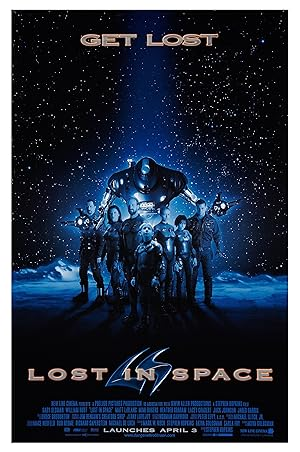


SUMMARY
Average time: 59.30ms
Total docs indexed: 1000

Query: 'Romantic comedy starring Julia Roberts with a cheerful poster'

Result 1 (score=0.6555):
  Movie: Baby Mama
  Year: 2008
  Poster text: Baby Mama. (2008). Comedy. directed by Michael McCullers. actors: Amy Poehler,  Tina Fey,  Greg Kinnear,  Dax Shepard,  Romany Malco.
  Poster image:


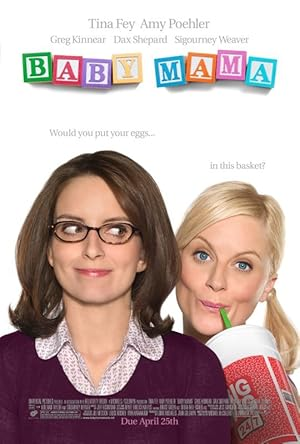


Result 2 (score=0.6847):
  Movie: The Other Woman
  Year: 2014
  Poster text: The Other Woman. (2014). Comedy. directed by Nick Cassavetes. actors: Cameron Diaz,  Leslie Mann,  Kate Upton,  Nikolaj Coster-Waldau,  Nicki Minaj.
  Poster image:


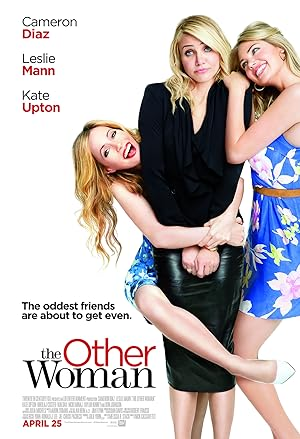


Result 3 (score=0.7026):
  Movie: Get a Job
  Year: 2016
  Poster text: Get a Job. (2016). Comedy. directed by Dylan Kidd. actors: Miles Teller,  Anna Kendrick,  Bryan Cranston,  Nicholas Braun,  Brandon T. Jackson.
  Poster image:


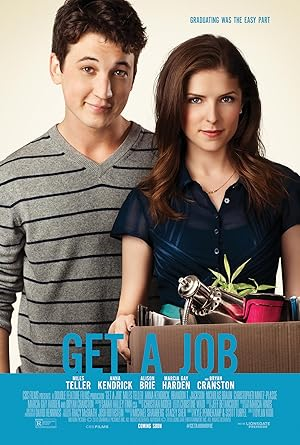


SUMMARY
Average time: 56.21ms
Total docs indexed: 1000

Query: 'Action thriller with Tom Cruise and a poster showing a car chase'

Result 1 (score=0.7017):
  Movie: All the Right Moves
  Year: 1983
  Poster text: All the Right Moves. (1983). Drama. directed by Michael Chapman. actors: Tom Cruise,  Craig T. Nelson,  Lea Thompson,  Charles Cioffi,  Paul Carafotes.
  Poster image:


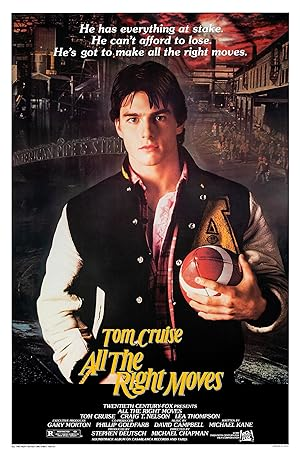


Result 2 (score=0.7056):
  Movie: Mission: Impossible - Fallout
  Year: 2018
  Poster text: Mission: Impossible - Fallout. (2018). Action & Adventure, Drama, Mystery & Suspense. directed by Christopher McQuarrie. actors: Tom Cruise,  Henry Cavill,  Ving Rhames,  Simon Pegg,  Rebecca Ferguson.
  Poster image:


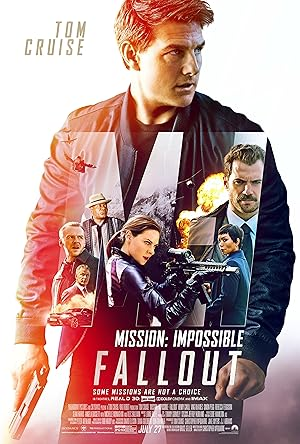


Result 3 (score=0.7126):
  Movie: Born on the Fourth of July
  Year: 1989
  Poster text: Born on the Fourth of July. (1989). Drama. directed by Oliver Stone. actors: Tom Cruise,  Kyra Sedgwick,  Caroline Kava,  Brian Larkin,  Willem Dafoe.
  Poster image:


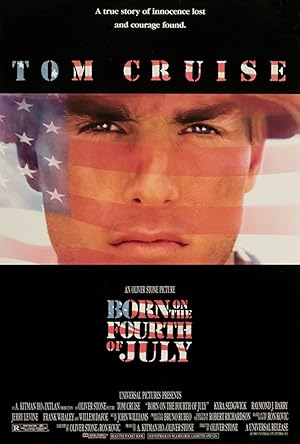


SUMMARY
Average time: 54.81ms
Total docs indexed: 1000

Saving retriever...


TypeError: Path.mkdir() got an unexpected keyword argument 'parents'

In [10]:
print(f"running visual retriever\n")
run(sample_docs, visual_retriever, test_queries, save=True)